Notebook Testing

In [1]:
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
from photutils.aperture import aperture_photometry, CircularAperture
from photutils import centroids
#%matplotlib inline

#plt.style.use(r"C:\Users\Sam Whitebook\Documents\GitHub\LocalTestRepository\Phys240.mplstyle")

In [2]:
files = sorted(glob.glob("F:/SDI/sec17/*.fz"))
hdus = [fits.open(f) for f in files] #opens fits files so we can access header data
data = [h[1].data for h in hdus] #array for image data
aligned = [aa.register(i, data[0])[0] for i in data[0:]]
template = np.mean(aligned, axis = 0)

bkg_phot = sep.Background(template)
extracted_phot = sep.extract(template - bkg_phot.back(),  bkg_phot.globalrms*3, minarea =25, segmentation_map=False) #find sources in image
w = WCS(hdus[0][1].header) #WCS matrix object

Set OBSGEO-B to    20.706958 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [3]:
references = []
mags = []
for src in extracted_phot: #indexes extracted sources by try number to find reference stars
    x = src['x']
    y = src['y']
    coord = pixel_to_skycoord(x, y, w).transform_to('icrs')
    search = SDSS.query_crossid(coord, fields = ['ra', 'dec', 'psfMag_g', 'psfMagErr_g'], radius = 15 * u.arcsec, region = False)
    if search: #if SDSS query returned results, continue
        if search['psfMag_g'] < 16 and search['type'] == 'STAR':
            ref = dict(ra = search['ra'], dec = search['dec'], x_coord = x, y_coord = y, x_min = src['xmin'], x_max = src['xmax'], g_mag = search['psfMag_g'], g_mag_err = search['psfMagErr_g'])
            references.append(ref)

for ref in references:
        coords = [ref['x_coord'], ref['y_coord']]
        radius = (ref['x_max'] - ref['x_min']) / 2
        app = CircularAperture(coords, radius) # takes instrumental mag at point
        app_phot = aperture_photometry(template - bkg_phot.back(), app)
        inst_mag = -2.5 * np.log10(float(app_phot['aperture_sum']))
        mag_cat = dict(inst_mag = inst_mag, inst_err = None, sky_mag = float(ref['g_mag']), sky_err = float(ref['g_mag_err'])) #Leaving an empty keyword for instrumental error calculated later
        mags.append(mag_cat)

348
0.8538640118477697 22.350859304907864


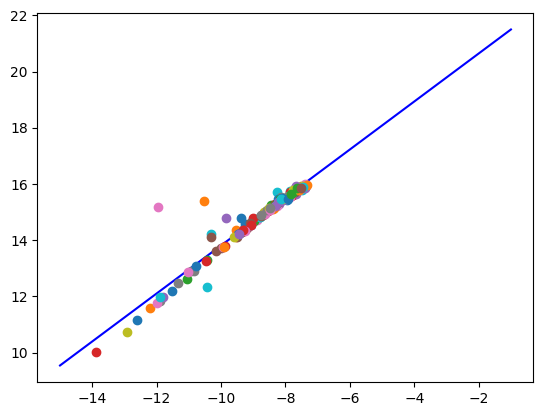

In [10]:
inst_mags = [mag['inst_mag'] for mag in mags]
sky_mags = [mag['sky_mag'] for mag in mags]
res = []

print(len(extracted_phot))
p = np.polyfit(inst_mags, sky_mags, deg= 1) #not great, not terrible
x = np.arange(-15, 0)
y = p[0]*x + p[1]
# y = x + 23.2
print(p[0], p[1])

plt.plot(x, y, color = 'b')

for star in mags:
    plt.errorbar(star['inst_mag'], star['sky_mag'], marker  = 'o', linestyle ='')
plt.show()

In [11]:

mags_final = []
for i, image in enumerate(data):
    bkg = sep.Background(image)
    print(i)
    for c, source in enumerate(extracted_phot):
        coords = [source['x'], source['y']]
        radius = (source['xmax'] - source['xmin']) / 2
        app = CircularAperture(coords, radius) # takes instrumental mag at point
        app_phot = aperture_photometry(image - bkg.back(), app)
        if app_phot['aperture_sum'][0] <= 0:
            inst_mag = 0
        else:
            inst_mag = -2.5 * np.log10(float(app_phot['aperture_sum'][0]))
        mag_coor = p[0] * inst_mag + p[1]
        info = dict(source_id = c, corrected_mag = mag_coor, x = source['x'], y = source['y'])
        mags_final.append(info)

print(mags_final)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



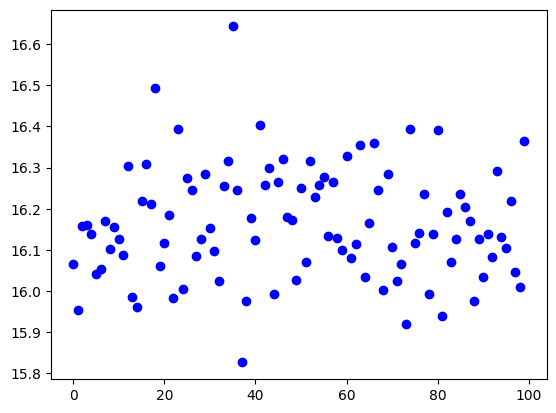

1073.5549992860922 9.977873225406888
1073.5549992860922 9.977873225406888
1073.5549992860922 9.977873225406888
1073.5549992860922 9.977873225406888
1073.5549992860922 9.977873225406888
1073.5549992860922 9.977873225406888
1073.5549992860922 9.977873225406888
1073.5549992860922 9.977873225406888
1073.5549992860922 9.977873225406888


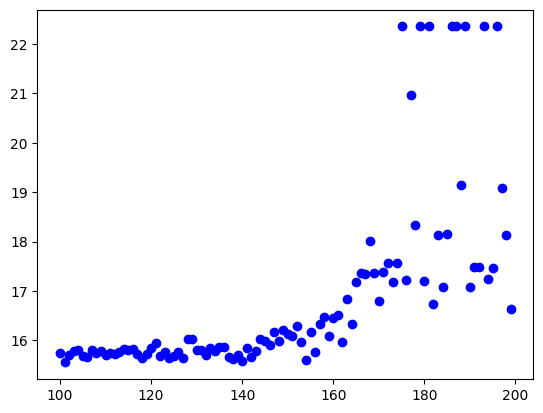

2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106
2977.0172276120666 20.588244447704106


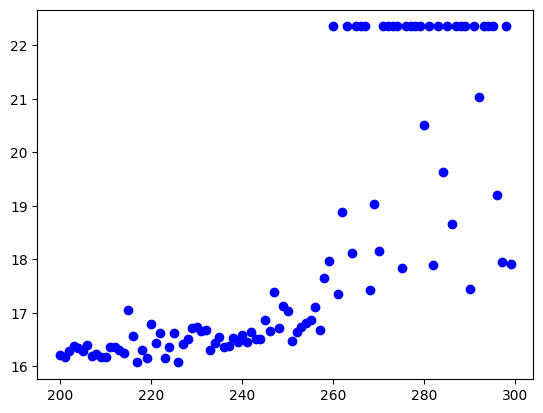

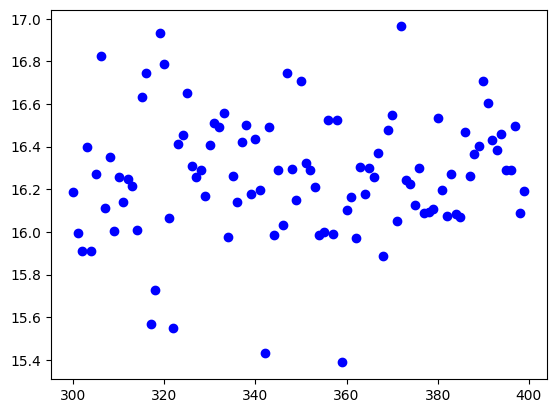

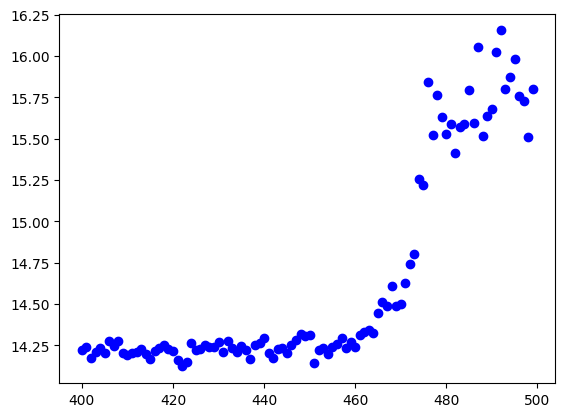

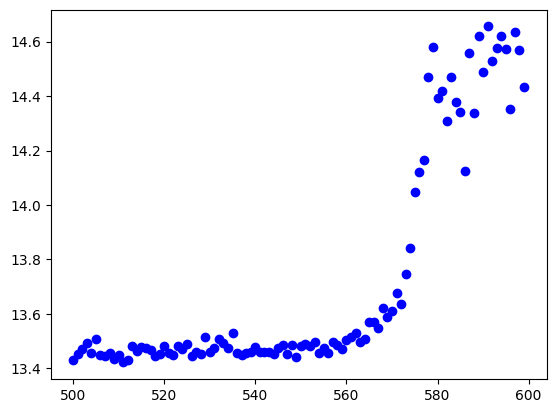

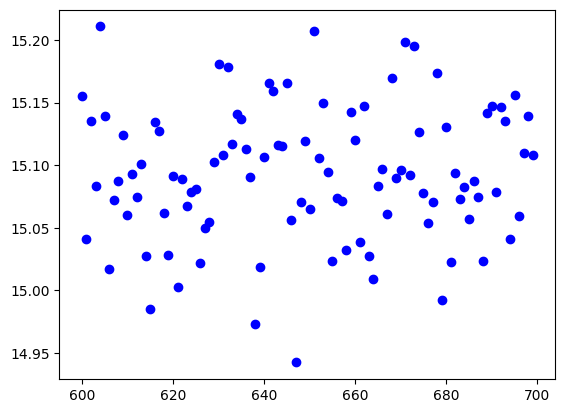

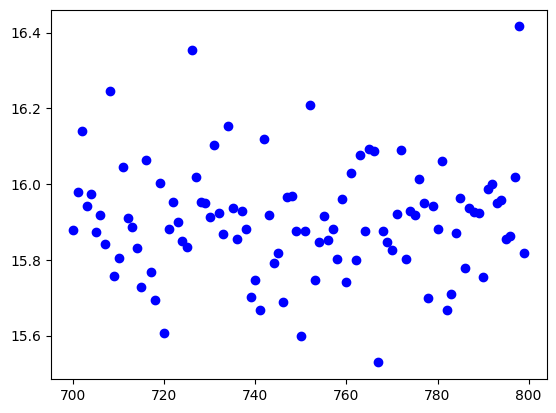

1279.629566911055 50.38760977085681
1279.629566911055 50.38760977085681
1279.629566911055 50.38760977085681
1279.629566911055 50.38760977085681
1279.629566911055 50.38760977085681
1279.629566911055 50.38760977085681
1279.629566911055 50.38760977085681
1279.629566911055 50.38760977085681
1279.629566911055 50.38760977085681
1279.629566911055 50.38760977085681


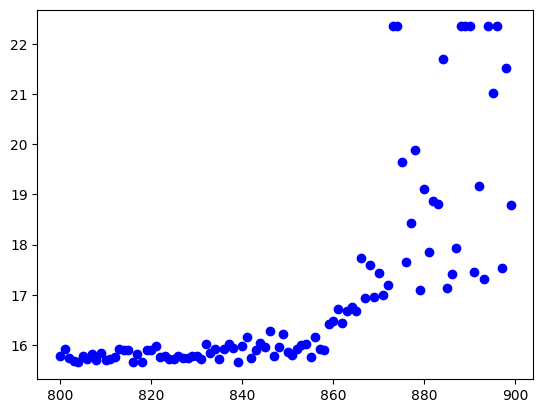

942.1227705172457 57.674108358304615
942.1227705172457 57.674108358304615
942.1227705172457 57.674108358304615
942.1227705172457 57.674108358304615
942.1227705172457 57.674108358304615
942.1227705172457 57.674108358304615
942.1227705172457 57.674108358304615
942.1227705172457 57.674108358304615
942.1227705172457 57.674108358304615
942.1227705172457 57.674108358304615
942.1227705172457 57.674108358304615
942.1227705172457 57.674108358304615
942.1227705172457 57.674108358304615
942.1227705172457 57.674108358304615


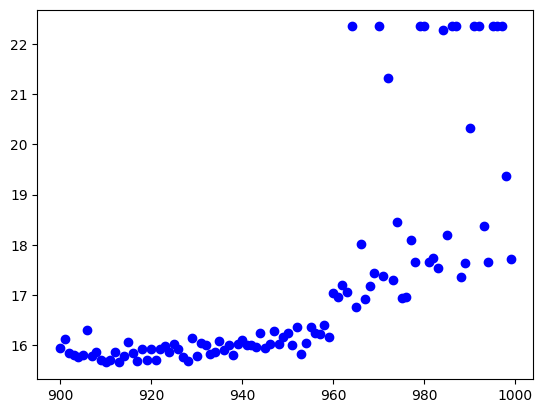

1893.9697322734191 82.06634670521842


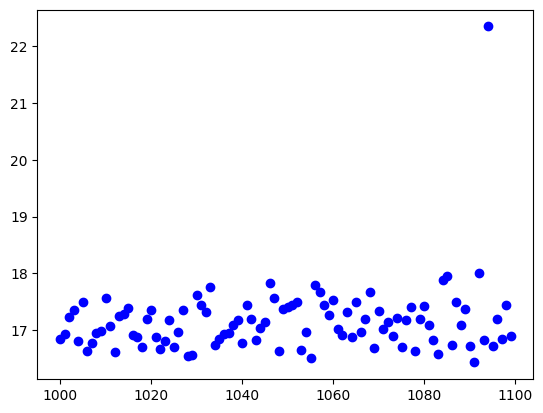

In [ ]:
r = np.arange(0, len(extracted_phot), 1)

i = 0
c = 0
while c != len(extracted_phot)-1:
    for mag in mags_final:
        if mag['source_id'] == c:
            plt.scatter(i, mag['corrected_mag'], color = 'b')
            if mag['corrected_mag'] > 20:
                print(mag['x'], mag['y'])
            i += 1
    c += 1
    plt.show()
